# Lab 3 - Phân loại thư rác với Naive Bayes

## Thông tin nhóm

## 1. Import thư viện, định nghĩa các hàm visualization và tải dữ liệu

In [39]:
# Các thư viện chuẩn
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import math
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

# các thư viện visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Đã import các thư viện.")

Đã import các thư viện.


In [40]:
# Lấy danh sách stop words
import nltk
from nltk.stem import PorterStemmer

try:
    # Thử tìm tài nguyên stopwords
    nltk.data.find('corpora/stopwords')
except LookupError:
    # Nếu không tìm thấy (gây ra LookupError), thì mới tải về
    print("Tài nguyên stopwords chưa được tải, đang tiến hành tải...")
    nltk.download('stopwords')

# Tải thêm tài nguyên 'punkt' nếu cần
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Tài nguyên punkt chưa được tải, đang tiến hành tải...")
    nltk.download('punkt')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

print("Đã tải và sẵn sàng sử dụng stopwords.")

Đã tải và sẵn sàng sử dụng stopwords.


In [41]:
# Các hàm Visualization

# Thiết lập style cho biểu đồ
sns.set(style="whitegrid")

def visualize_label_distribution(df, title='Phân phối nhãn'):
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='Spam/Ham', data=df, palette=['#ff6347', '#4682b4'])
    plt.title(title, fontsize=16)
    plt.xlabel("Loại Email", fontsize=12)
    plt.ylabel("Số lượng", fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Spam', 'Ham'])
    y_max = df['Spam/Ham'].value_counts().max()
    ax.set_ylim(0, y_max * 1.1)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    fontsize=12,
                    color='black',
                    xytext=(0, 9),
                    textcoords='offset points')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    classes = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.xlabel("Nhãn dự đoán", fontsize=12)
    plt.ylabel("Nhãn thực tế", fontsize=12)
    plt.show()

def visualize_top_words(top_words, class_name):
    n = min(20, len(top_words))
    words = [word for word, score in top_words]
    scores = [score for word, score in top_words]
    plt.figure(figsize=(10, 8))
    colors = '#ff6347' if class_name == 'spam' else '#4682b4'
    sns.barplot(x=scores, y=words, palette=[colors])
    plt.title(f"Top {n} từ quan trọng nhất cho lớp '{class_name.upper()}'", fontsize=16)
    plt.xlabel("Log Odds Ratio Score", fontsize=12)
    plt.ylabel("Từ", fontsize=12)
    plt.show()

def visualize_alpha_performance(results):
    alphas = [r['alpha'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    plt.figure(figsize=(12, 7))
    plt.plot(alphas, accuracies, marker='o', linestyle='-', color='b', markersize=8)
    plt.title('Hiệu suất của mô hình với các giá trị Alpha khác nhau', fontsize=16)
    plt.xlabel('Alpha (Hệ số Smoothing)', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.xscale('log')
    plt.xticks(alphas, labels=alphas)
    plt.grid(True, which="both", ls="--")
    plt.show()

In [42]:
# hàm đọc dữ liệu
def load_data(file_path):
    try:
      data = pd.read_csv(file_path, on_bad_lines='skip', engine='python')
      return data
    except Exception as e:
      print(f"Có lỗi xảy ra trong quá trình đọc dữ liệu từ '{file_path}': {e}")
      return None

In [43]:
# Đọc dữ liệu
print("Đang tải dữ liệu...")

train_data = load_data('train.csv')
print("\nĐã tải xong dữ liệu train!")

val_data = load_data('val.csv')
print("\nĐã tải xong dữ liệu val!")

Đang tải dữ liệu...

Đã tải xong dữ liệu train!

Đã tải xong dữ liệu val!


In [44]:
print(f"Kích thước tập train: {train_data.shape}")
print(f"Kích thước tập validation: {val_data.shape}")
print("\n5 dòng đầu tiên của tập train:")
train_data.head()

Kích thước tập train: (27284, 6)
Kích thước tập validation: (3084, 6)

5 dòng đầu tiên của tập train:


,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,0,0,christmas tree farm pictures,NaN,ham,0.038415
1,1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0.696509
2,2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0.587792
3,3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,-0.055438
4,5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,-0.419658


## 2. Tiền xử lý dữ liệu

### 2.1 Kiểm tra và clean dữ liệu

In [45]:
# Kiểm tra dữ liệu null
print("Kiểm tra dữ liệu null:")
print(train_data.isnull().sum())
print("\nKiểm tra dữ liệu null trong val set:")
print(val_data.isnull().sum())

# Kiểm tra dữ liệu trùng lặp
print(f"\nSố dòng trùng lặp trong train: {train_data.duplicated().sum()}")
print(f"Số dòng trùng lặp trong val: {val_data.duplicated().sum()}")

Kiểm tra dữ liệu null:
Unnamed: 0      0
Message ID      0
Subject       229
Message       352
Spam/Ham        0
split           0
dtype: int64

Kiểm tra dữ liệu null trong val set:
Unnamed: 0     0
Message ID     0
Subject       29
Message       35
Spam/Ham       0
split          0
dtype: int64

Số dòng trùng lặp trong train: 0
Số dòng trùng lặp trong val: 0


In [46]:
# Hàm clean dữ liệu
def clean_data(df):
  try:
    # Điền giá trị rỗng cho Message nếu có
    df['Message'] = df['Message'].fillna('')

    # Loại bỏ dòng trùng lặp nếu có
    df = df.drop_duplicates().reset_index(drop=True)

  except Exception as e:
    print(f"Có lỗi xảy ra trong quá trình làm sạch dữ liệu: {e}")

In [47]:
print("Clean dữ liệu...")

clean_data(train_data)
clean_data(val_data)

print("\nHòan tất clean dữ liệu!")

Clean dữ liệu...

Hòan tất clean dữ liệu!


Phân phối nhãn trong tập train:


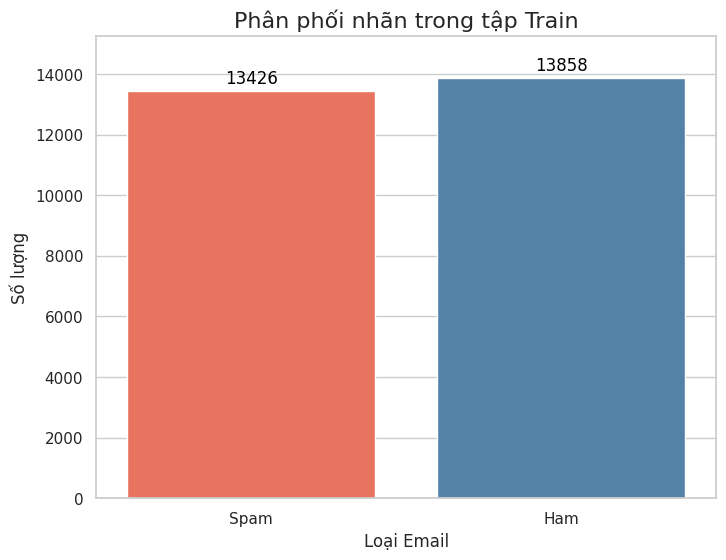


Phân phối nhãn trong tập val:


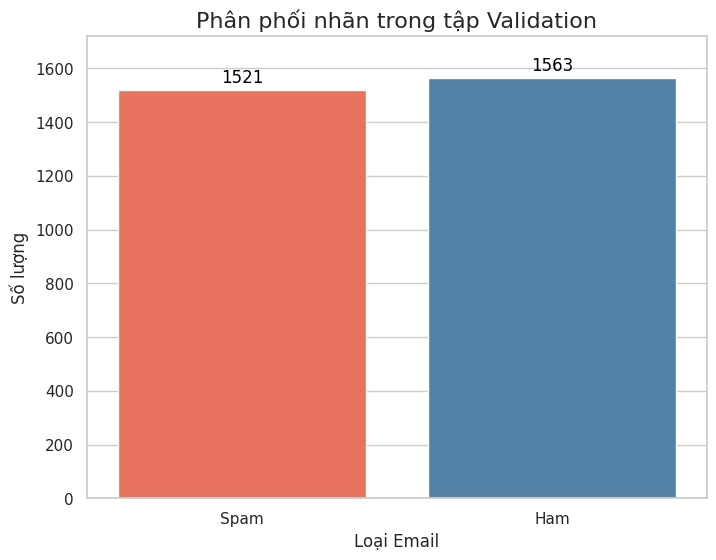

In [48]:
# Kiểm tra phân phối nhãn
print("Phân phối nhãn trong tập train:")
visualize_label_distribution(train_data, title='Phân phối nhãn trong tập Train')

print("\nPhân phối nhãn trong tập val:")
visualize_label_distribution(val_data, title='Phân phối nhãn trong tập Validation')

### 2.2 Tiền xử lý văn bản

In [49]:
def preprocess_text(text):
    """
    Hàm tất tiền xử lí với các bước:
    1. Trích xuất đặc trưng từ văn bản THÔ (subject, message).
    2. Tạo token đặc trưng:
      + Tỷ lệ chữ in hoa
      + Ký tự đặc biệt
      + Chữ số
    3. Tiền xử lý (làm sạch) văn bản:
      + Chuyển về chữ thường
      + Loại bỏ ký tự đặc biệt, giữ lại chữ và số
      + Loại bỏ khoảng trắng thừa
    4. Kết hợp token đặc trưng và văn bản đã làm sạch thành một chuỗi duy nhất.
    """
    # Trích xuất
    subject = text['Subject']
    message = text['Message']

    # Tạo token đặc trưng từ dữ liệu thô
    full_text_raw = str(subject) + " " + str(message)
    text_len = len(full_text_raw)
    feature_tokens = []

    if text_len > 0:
        # Tỷ lệ chữ in hoa
        uppercase_count = sum(1 for char in full_text_raw if char.isupper())
        caps_ratio = uppercase_count / text_len
        if caps_ratio > 0.5:
            feature_tokens.append('__FEAT_VERY_HIGH_CAPS__')
        elif caps_ratio > 0.2:
            feature_tokens.append('__FEAT_HIGH_CAPS__')

        # Ký tự đặc biệt
        special_chars = len(re.findall(r'[!$%*&£€]', full_text_raw))
        if special_chars > 5:
            feature_tokens.append('__FEAT_MANY_SPECIALS__')

        # Chữ số
        digit_count = sum(1 for char in full_text_raw if char.isdigit())
        if digit_count > 10:
            feature_tokens.append('__FEAT_MANY_DIGITS__')

    feature_token_string = ' '.join(feature_tokens)

    # Tiền xử lý văn bản
    # Chuyển về chữ thường
    processed_text = full_text_raw.lower()
    # Loại bỏ ký tự đặc biệt, giữ lại chữ và số
    processed_text = re.sub(r'[^a-zA-Z0-9\\s]', ' ', processed_text)
    # Loại bỏ khoảng trắng thừa
    processed_text = ' '.join(processed_text.split())

    # Kết hợp và trả về
    return feature_token_string + ' ' + processed_text

In [50]:
# Áp dụng tiền xử lý cho dữ liệu
print("Đang áp dụng tiền xử lý...")

# Áp dụng hàm preproces cho tập train
train_data['processed_text'] = train_data.apply(preprocess_text, axis=1)

# Áp dụng hàm preproces cho tập validation
val_data['processed_text'] = val_data.apply(preprocess_text, axis=1)

print("\nHoàn tất! Ví dụ 5 văn bản đầu sau khi tiền xử lý:")
train_data[['processed_text']].head()

Đang áp dụng tiền xử lý...

Hoàn tất! Ví dụ 5 văn bản đầu sau khi tiền xử lý:


,processed_text
0,christmas tree farm pictures
1,__FEAT_MANY_DIGITS__ vastar resources inc gary...
2,calpine daily gas nomination calpine daily ga...
3,__FEAT_MANY_DIGITS__ re issue fyi see note bel...
4,__FEAT_MANY_DIGITS__ mcmullen gas for 11 99 ja...


## 3. Xây dựng mô hình Naive Bayes từ đầu

### 3.1 Lý thuyết Naive Bayes

Naive Bayes Classifier cho phân loại văn bản:

1. Theo Bayes' theorem:
   P(class|document) = P(document|class) * P(class) / P(document)

2. Với giả định Naive Bayes (độc lập có điều kiện):
   P(document|class) = P(word1|class) * P(word2|class) * ... * P(wordn|class)

3. Sử dụng log probability để tránh underflow:
   log P(class|document) = log P(class) + Σ log P(word|class)

4. Laplace smoothing để xử lý từ chưa xuất hiện:
   P(word|class) = (count(word, class) + α) / (count(all words in class) + α * |V|)
   với α = 0.1 (Laplace smoothing), |V| là kích thước từ vựng

Quy trình của hàm 'tokenizer_with_bigrams':

  - Tách từ và loại bỏ stop words: Tách văn bản thành các từ và loại bỏ những từ phổ biến, không mang nhiều ý nghĩa.

  - Stemming: Đưa các từ về dạng gốc (ví dụ running -> run).

  - Tạo Bigrams: Ghép mỗi cặp từ liền kề (đã được stem) thành một token duy nhất (ví dụ buy_now).

Kết quả: Trả về một danh sách bao gồm cả các từ đơn và các cặp từ đã được xử lý.

In [51]:
# Tokenize + bigrams
def tokenizer_with_bigrams(text, stop_words_set, stemmer):
    """
    Hàm tokenizer, stemming, tạo unigrams, bigrams.
    """
    # Tokenize và loại bỏ stop words
    words = text.split()
    unigrams = [word for word in words if word not in stop_words_set]

    # Stemming
    stemmed_unigrams = [stemmer.stem(word) for word in unigrams]

    # Tạo bigrams từ các từ đã stem
    bigrams = ['_'.join(pair) for pair in zip(stemmed_unigrams, stemmed_unigrams[1:])]

    return stemmed_unigrams + bigrams

### 3.2 Cài đặt Naive Bayes Classifier


In [78]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0, tokenizer=None):
        """
        Khởi tạo Naive Bayes Classifier

        Parameters:
        - alpha: Tham số smoothing (mặc định = 1.0 cho Laplace smoothing)
        - tokenizer: Hàm tokenizer, mặc định là _default_tokenizer
        """
        self.alpha = alpha
        self.class_priors = {}
        self.word_probs = {}
        self.classes = []
        self.vocab = set()
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

        if tokenizer:
            self.tokenizer = lambda text: tokenizer(text, self.stop_words, self.stemmer)
        else:
            self.tokenizer = self._default_tokenizer

    def _default_tokenizer(self, text):
        """ Tách văn bản thành các từ, loại bỏ stop words và stemming """
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        words = [self.stemmer.stem(word) for word in words]
        return words

    def fit(self, X_train, y_train):
        """
        Huấn luyện mô hình Naive Bayes

        Parameters:
        - X_train: Danh sách văn bản đã tiền xử lý
        - y_train: Nhãn tương ứng
        """
        print("Bắt đầu huấn luyện mô hình:")

        print("\n - Các tham số:")
        print(f"  + Alpha: {self.alpha}")
        tokenizer_name = "tokenizer_with_bigrams" if self.tokenizer else "_default_tokenizer"
        print(f"  + Tokenizer: {tokenizer_name}")

        # Lấy danh sách các lớp
        self.classes = list(set(y_train))
        n_docs = len(y_train)

        # Tính prior probability cho mỗi lớp
        print("\n - Tính prior probability...")
        for c in self.classes:
            self.class_priors[c] = sum(1 for y in y_train if y == c) / n_docs
            print(f"  + P({c}) = {self.class_priors[c]:.4f}")


        # 1. Đếm tất cả các từ trong tập train trước
        print("\n - Đang đếm từ để xây dựng vocabulary...")
        word_counts = {c: Counter() for c in self.classes}
        all_words_counter = Counter()

        for text, label in zip(X_train, y_train):
            words = self.tokenizer(text)
            word_counts[label].update(words)
            all_words_counter.update(words)

        # 2. Cắt tỉa (pruning) để tạo bộ từ vựng cuối cùng
        min_frequency = 3
        self.vocab = {word for word, count in all_words_counter.items() if count >= min_frequency}
        vocab_size = len(self.vocab)
        print(f"  + Tổng số từ duy nhất ban đầu: {len(all_words_counter)}")
        print(f"  + Kích thước từ vựng sau khi lọc (xuất hiện >= {min_frequency} lần): {vocab_size}")

        # 3. Tính likelihood với Laplace smoothing dựa trên từ vựng đã lọc
        print("\n - Tính likelihood với Laplace smoothing...")
        self.word_probs = {c: {} for c in self.classes}

        for c in self.classes:
            # Lấy tổng số từ của lớp c (chỉ tính các từ trong vocab)
            total_words_in_class = sum(word_counts[c][word] for word in self.vocab)
            print(f"\n - Lớp {c}: {total_words_in_class} từ (trong vocab)")

            # Tính P(word|class) cho mỗi từ trong vocabulary
            for word in self.vocab:
                count = word_counts[c].get(word, 0)
                self.word_probs[c][word] = (count + self.alpha) / (total_words_in_class + self.alpha * vocab_size)

            # Xác suất cho từ chưa từng xuất hiện (unknown words)
            self.word_probs[c]['<UNK>'] = self.alpha / (total_words_in_class + self.alpha * vocab_size)

        print("\nHuấn luyện hoàn tất!")
        return self

    def _predict_single(self, text):
        """
        Dự đoán nhãn cho một văn bản
        Returns: (predicted_class, log_probabilities)
        """
        words = self.tokenizer(text) # Tokenize và stem

        log_probs = {}
        for c in self.classes:
            log_prob = math.log(self.class_priors[c])
            for word in words:
                # Nếu từ có trong dict xác suất của lớp c
                if word in self.word_probs[c]:
                    log_prob += math.log(self.word_probs[c][word])
                else:
                    # Từ không có trong vocab (đã bị lọc) hoặc mới, dùng xác suất UNK
                    log_prob += math.log(self.word_probs[c]['<UNK>'])
            log_probs[c] = log_prob

        predicted_class = max(log_probs, key=log_probs.get)
        return predicted_class, log_probs

    def predict(self, X_test):
        """Dự đoán nhãn cho tập văn bản"""
        predictions = []
        log_probs = []
        for text in X_test:
            pred, log_prob = self._predict_single(text)
            predictions.append(pred)
            log_probs.append(log_prob)
        return predictions, log_probs

    # Hàm predict_proba không thay đổi
    def predict_proba(self, X_test):
        proba_list = []
        for text in X_test:
            _, log_probs = self._predict_single(text)
            max_log_prob = max(log_probs.values())
            exp_probs = {c: math.exp(log_prob - max_log_prob) for c, log_prob in log_probs.items()}
            total = sum(exp_probs.values())
            probs = {c: exp_prob / total for c, exp_prob in exp_probs.items()}
            proba_list.append(probs)
        return proba_list

### 3.3 Huấn luyện mô hình

In [106]:
# Khởi tạo mô hình
nb_classifier = NaiveBayesClassifier(alpha=0.1, tokenizer=tokenizer_with_bigrams) # đã qua chạy thử nghiệm nên chọn alpha = 0.1 để tối ưu

In [107]:
# Chuẩn bị dữ liệu
X_train = train_data['processed_text'].values
y_train = train_data['Spam/Ham'].values

In [108]:
# Huấn luyện mô hình
nb_classifier.fit(X_train, y_train)

Bắt đầu huấn luyện mô hình:

 - Các tham số:
  + Alpha: 0.1
  + Tokenizer: tokenizer_with_bigrams

 - Tính prior probability...
  + P(ham) = 0.4921
  + P(spam) = 0.5079

 - Đang đếm từ để xây dựng vocabulary...
  + Tổng số từ duy nhất ban đầu: 1347221
  + Kích thước từ vựng sau khi lọc (xuất hiện >= 3 lần): 301688

 - Tính likelihood với Laplace smoothing...

 - Lớp ham: 3423355 từ (trong vocab)

 - Lớp spam: 3117026 từ (trong vocab)

Huấn luyện hoàn tất!


### 3.4 Đánh giá mô hình

In [83]:
def evaluate_model(y_true, y_pred):
    """
    Đánh giá mô hình với các metrics:
    - Accuracy
    - Precision, Recall, F1-score cho mỗi lớp
    - Visualize Confusion Matrix
    """
    # Accuracy
    accuracy = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred)) / len(y_true)

    # Confusion Matrix và metrics cho mỗi lớp
    classes = list(set(y_true))
    metrics = {}

    for c in classes:
        # True Positive, False Positive, False Negative, True Negative
        tp = sum((y_t == c) and (y_p == c) for y_t, y_p in zip(y_true, y_pred))
        fp = sum((y_t != c) and (y_p == c) for y_t, y_p in zip(y_true, y_pred))
        fn = sum((y_t == c) and (y_p != c) for y_t, y_p in zip(y_true, y_pred))
        tn = sum((y_t != c) and (y_p != c) for y_t, y_p in zip(y_true, y_pred))

        # Precision, Recall, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        metrics[c] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
        }

    return accuracy, metrics

            Đánh giá trên tập train

Accuracy: 0.9963

Lớp 'ham':
 - Precision: 0.9958
 - Recall: 0.9967
 - F1-score: 0.9963

Lớp 'spam':
 - Precision: 0.9968
 - Recall: 0.9960
 - F1-score: 0.9964

Confusion Matrix:


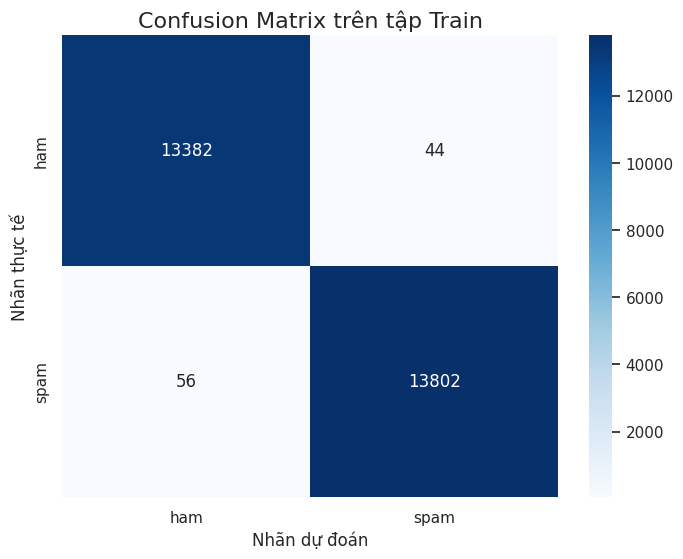

In [109]:
# Đánh giá trên tập train
print("="*50)
print("            Đánh giá trên tập train")
print("="*50)

train_predictions, _ = nb_classifier.predict(X_train)
train_accuracy, train_metrics = evaluate_model(y_train, train_predictions)

print(f"\nAccuracy: {train_accuracy:.4f}")
for c in train_metrics:
    m = train_metrics[c]
    print(f"\nLớp '{c}':")
    print(f" - Precision: {m['precision']:.4f}")
    print(f" - Recall: {m['recall']:.4f}")
    print(f" - F1-score: {m['f1']:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
visualize_confusion_matrix(y_train, train_predictions, title='Confusion Matrix trên tập Train')

          Đánh giá trên tập validation

Accuracy: 0.9903

Lớp 'ham':
  Precision: 0.9901
  Recall: 0.9901
  F1-score: 0.9901

Lớp 'spam':
  Precision: 0.9904
  Recall: 0.9904
  F1-score: 0.9904

Confusion Matrix:


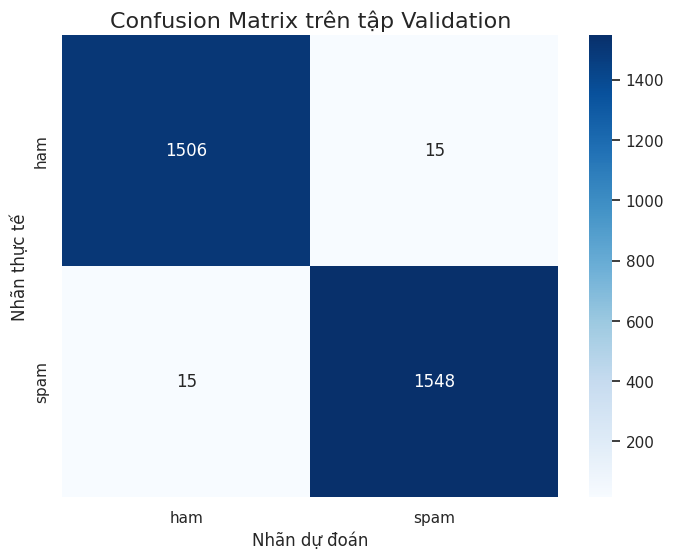

In [110]:
# Đánh giá trên tập validation
print("="*50)
print("          Đánh giá trên tập validation")
print("="*50)

X_val = val_data['processed_text'].values
y_val = val_data['Spam/Ham'].values

val_predictions, _ = nb_classifier.predict(X_val)
val_accuracy, val_metrics = evaluate_model(y_val, val_predictions)

print(f"\nAccuracy: {val_accuracy:.4f}")
for c in val_metrics:
    m = val_metrics[c]
    print(f"\nLớp '{c}':")
    print(f"  Precision: {m['precision']:.4f}")
    print(f"  Recall: {m['recall']:.4f}")
    print(f"  F1-score: {m['f1']:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
visualize_confusion_matrix(y_val, val_predictions, title='Confusion Matrix trên tập Validation')

### 3.5 Phân tích các dự đoán sai

In [86]:
def analyze_errors(y_true, y_pred, data):
    print("=== PHÂN TÍCH DỰ ĐOÁN SAI ===")
    # In ra 5 email ham bị đoán SAI là spam (False Positives)
    fp_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == 'ham' and pred == 'spam']
    print(f"\n--- {len(fp_indices)} False Positives (Ham -> Spam) ---")
    for i in fp_indices[:5]:
        print(f"Email {i}:")
        print(f"  Subject: \"{data.iloc[i]['Subject']}\"")
        print(f"  Message: \"{str(data.iloc[i]['Message'])[:50]}...\"")
    print("-" * 50)

    # In ra 5 email spam bị đoán SAI là ham (False Negatives)
    fn_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == 'spam' and pred == 'ham']
    print(f"\n--- {len(fn_indices)} False Negatives (Spam -> Ham) ---")
    for i in fn_indices[:5]:
        print(f"Email {i}:")
        print(f"  Subject: \"{data.iloc[i]['Subject']}\"")
        print(f"  Message: \"{str(data.iloc[i]['Message'])[:50]}...\"")
    print("-" * 50)

In [87]:
analyze_errors(y_val, val_predictions, val_data)

=== PHÂN TÍCH DỰ ĐOÁN SAI ===

--- 19 False Positives (Ham -> Spam) ---
Email 18:
  Subject: "tech - support @ service . juno . com : problems retrieving mail"
  Message: "daren i guess i need help with this too ! love you..."
Email 26:
  Subject: "valentines day help"
  Message: "red - neck valentine ' s love poem
collards is gre..."
Email 48:
  Subject: "wassup - south park"
  Message: "- wassupsouthparkl . exe..."
Email 58:
  Subject: "registration confirmation - my yahoo !"
  Message: "account information
help
do not reply to this mess..."
Email 276:
  Subject: "please note my new email address"
  Message: "effective today , please send future correspondenc..."
--------------------------------------------------

--- 14 False Negatives (Spam -> Ham) ---
Email 357:
  Subject: "re : no more injections"
  Message: "..."
Email 1519:
  Subject: "peter g [ tour dates ]"
  Message: "tour dates
friday 8 th - regua open air
saturday 9..."
Email 1804:
  Subject: "all alone ? need somoene to t

## 4. Thử nghiệm thực tế

### 4.1 Chức năng 1: Dự đoán email người dùng nhập

In [88]:
def predict_user_email():
    """
    Cho phép người dùng nhập email và dự đoán spam/ham
    """
    print("=== DỰ ĐOÁN EMAIL NHẬP THỦ CÔNG ===")
    subject = input("Nhập tiêu đề email: ")
    message = input("Nhập nội dung email: ")

    # Tiền xử lý
    predict_text = preprocess_text({'Subject': subject, 'Message': message})

    # Dự đoán
    prediction, log_probs = nb_classifier._predict_single(predict_text)

    # Tính xác suất
    max_log_prob = max(log_probs.values())
    exp_probs = {c: math.exp(log_prob - max_log_prob)
                for c, log_prob in log_probs.items()}
    total = sum(exp_probs.values())
    probs = {c: exp_prob / total for c, exp_prob in exp_probs.items()}

    print(f"\nKết quả dự đoán: {prediction.upper()}")
    print(f"Xác suất spam: {probs['spam']:.4f}")
    print(f"Xác suất ham: {probs['ham']:.4f}")

    return prediction, probs

In [122]:
# Test
prediction, probs = predict_user_email()

=== DỰ ĐOÁN EMAIL NHẬP THỦ CÔNG ===
Nhập tiêu đề email: 50% offf Iphone 16
Nhập nội dung email: Only for today

Kết quả dự đoán: SPAM
Xác suất spam: 0.9913
Xác suất ham: 0.0087


### 4.2 Chức năng 2: Đánh giá file CSV


In [135]:
def evaluate_csv_file(filename, model):
    """
    Đọc và đánh giá mô hình trên file CSV
    File CSV cần có cấu trúc giống val.csv
    """
    print(f"=== ĐÁNH GIÁ DỰ ĐOÁN FILE: {filename} ===")

    try:
        # Đọc file
        data = pd.read_csv(filename,  on_bad_lines='skip', engine='python')
        print(f"\nĐã đọc {len(data)} dòng từ file")

        # Kiểm tra cấu trúc
        required_cols = ['Subject', 'Message', 'Spam/Ham']
        if not all(col in data.columns for col in required_cols):
            print("\nLỗi: File không có đủ các cột cần thiết!")
            print(f" - Cần có: {required_cols}")
            print(f" - File có: {list(data.columns)}")
            return

        # Clean data
        clean_data(data)

        # Tiền xử lý
        data['processed_text'] = data.apply(preprocess_text, axis=1)

        # Dự đoán
        X_test = data['processed_text'].values
        y_test = data['Spam/Ham'].values
        predictions, _ = model.predict(X_test)

        # Đánh giá
        accuracy, metrics = evaluate_model(y_test, predictions)

        print(f"\nKết quả đánh giá:")
        print(f" - Accuracy: {accuracy:.4f}")

        for c in metrics:
            m = metrics[c]
            print(f"\n - Lớp '{c}':")
            print(f"   + Precision: {m['precision']:.4f}")
            print(f"   + Recall: {m['recall']:.4f}")
            print(f"   + F1-score: {m['f1']:.4f}")

    except Exception as e:
        print(f"Lỗi khi đọc file: {e}")

In [136]:
# Test với tập val
evaluate_csv_file('val.csv', model = nb_classifier)

=== ĐÁNH GIÁ DỰ ĐOÁN FILE: val.csv ===

Đã đọc 3084 dòng từ file

Kết quả đánh giá:
 - Accuracy: 0.9903

 - Lớp 'ham':
   + Precision: 0.9901
   + Recall: 0.9901
   + F1-score: 0.9901

 - Lớp 'spam':
   + Precision: 0.9904
   + Recall: 0.9904
   + F1-score: 0.9904


## 5. Phân tích và cải thiện


### 5.1 Phân tích các từ quan trọng


In [92]:
def get_top_words_per_class(n=20):
    print(f"=== TOP {n} TỪ QUAN TRỌNG CHO MỖI LỚP ===")

    for c in nb_classifier.classes:
        # Lấy log odds ratio: log(P(word|class)) - log(P(word|not_class))
        word_scores = {}

        for word in nb_classifier.vocab:
            if word in nb_classifier.word_probs[c]:
                # Log probability của từ trong lớp hiện tại
                log_prob_c = math.log(nb_classifier.word_probs[c][word])

                # Log probability trung bình của từ trong các lớp khác
                other_classes = [cls for cls in nb_classifier.classes if cls != c]
                avg_log_prob_other = sum(math.log(nb_classifier.word_probs[cls].get(word,
                                                  nb_classifier.word_probs[cls]['<UNK>']))
                                        for cls in other_classes) / len(other_classes)

                # Score = difference
                word_scores[word] = log_prob_c - avg_log_prob_other

        # Sắp xếp và lấy top n
        top_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:n]

        # visualize
        print(f"\nLớp '{c}':")
        visualize_top_words(top_words, c)

=== TOP 10 TỪ QUAN TRỌNG CHO MỖI LỚP ===

Lớp 'ham':


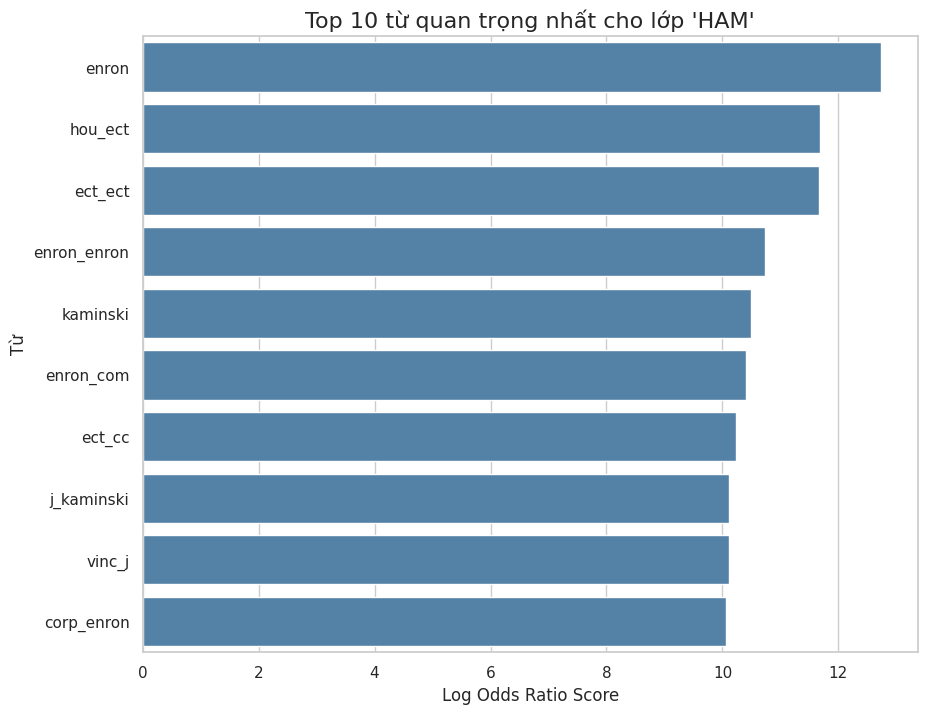


Lớp 'spam':


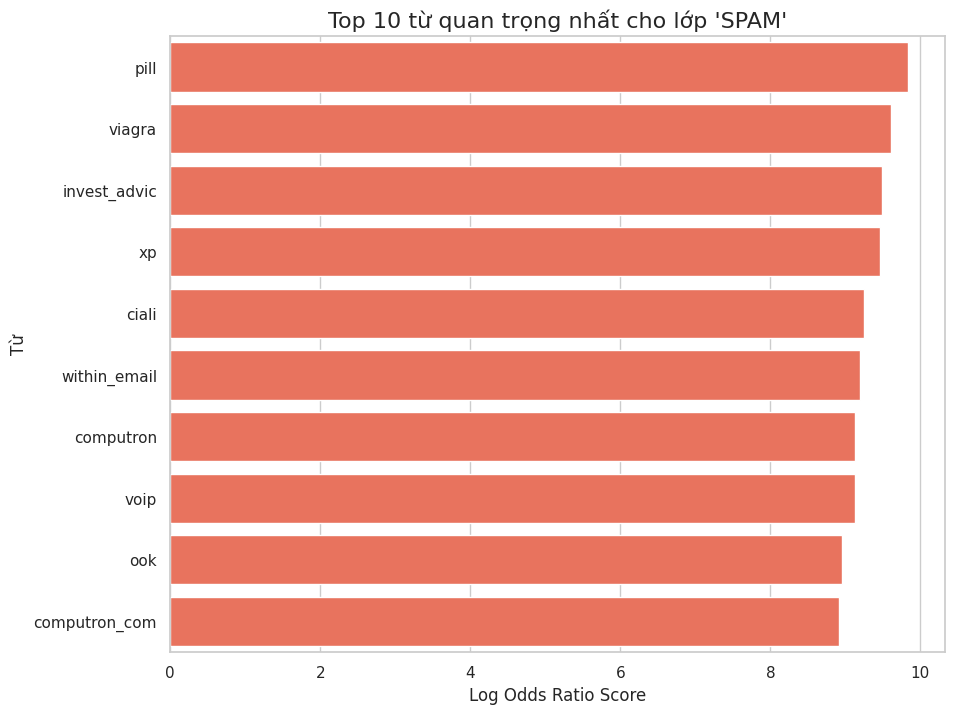

In [137]:
get_top_words_per_class(10)

### 5.2 Thử nghiệm với các tham số smoothing khác nhau

In [94]:
print("=== THỬ NGHIỆM VỚI CÁC GIÁ TRỊ ALPHA KHÁC NHAU ===\n")

# Các threshold được tạo thủ công
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

for alpha in alphas:
    print("=" * 50)
    print(" " * 19 + f"Alpha = {alpha}")
    print("=" * 50)

    # Train model với alpha mới
    nb_temp = NaiveBayesClassifier(alpha=alpha, tokenizer=tokenizer_with_bigrams)
    nb_temp.fit(X_train, y_train)

    # Đánh giá
    val_pred, _ = nb_temp.predict(X_val)
    accuracy, _ = evaluate_model(y_val, val_pred)

    # In kết quả
    results.append({'alpha': alpha, 'accuracy': accuracy})
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\n")

=== THỬ NGHIỆM VỚI CÁC GIÁ TRỊ ALPHA KHÁC NHAU ===

                   Alpha = 0.1
Bắt đầu huấn luyện mô hình:

 - Các tham số:
  + Alpha: 0.1
  + Tokenizer: tokenizer_with_bigrams

 - Tính prior probability...
  + P(ham) = 0.4921
  + P(spam) = 0.5079

 - Đang đếm từ để xây dựng vocabulary...
  + Tổng số từ duy nhất ban đầu: 1347221
  + Kích thước từ vựng sau khi lọc (xuất hiện >= 3 lần): 301688

 - Tính likelihood với Laplace smoothing...

 - Lớp ham: 3423355 từ (trong vocab)

 - Lớp spam: 3117026 từ (trong vocab)

Huấn luyện hoàn tất!
Validation Accuracy: 0.9903


                   Alpha = 0.5
Bắt đầu huấn luyện mô hình:

 - Các tham số:
  + Alpha: 0.5
  + Tokenizer: tokenizer_with_bigrams

 - Tính prior probability...
  + P(ham) = 0.4921
  + P(spam) = 0.5079

 - Đang đếm từ để xây dựng vocabulary...
  + Tổng số từ duy nhất ban đầu: 1347221
  + Kích thước từ vựng sau khi lọc (xuất hiện >= 3 lần): 301688

 - Tính likelihood với Laplace smoothing...

 - Lớp ham: 3423355 từ (trong voca

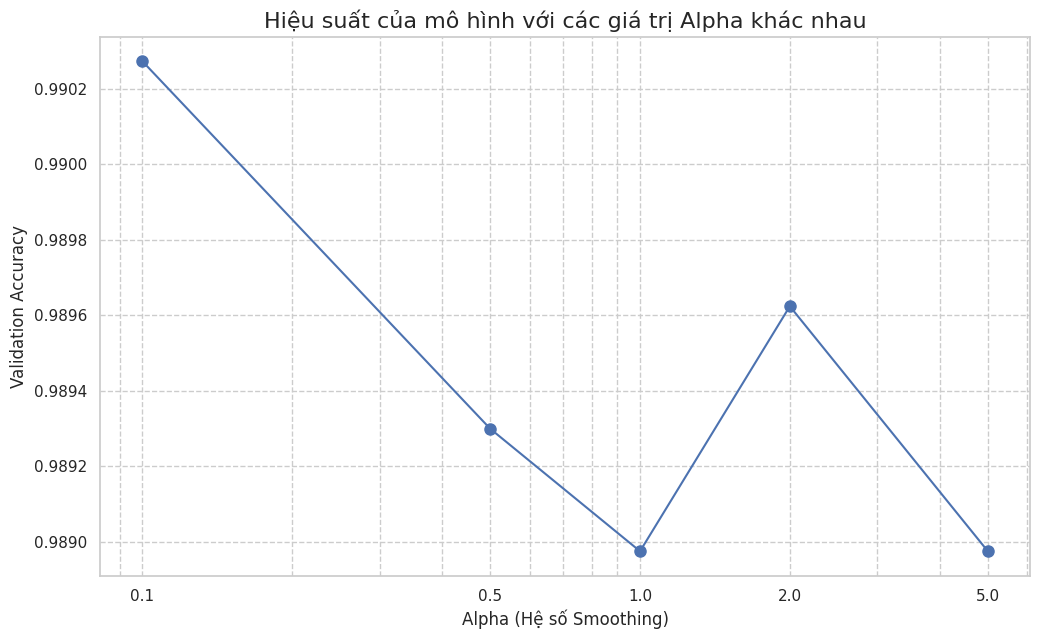

In [125]:
# visualize
visualize_alpha_performance(results)

In [96]:
# Tìm alpha tốt nhất
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\nAlpha tốt nhất là {best_result['alpha']} với accuracy: {best_result['accuracy']:.4f}")


Alpha tốt nhất là 0.1 với accuracy: 0.9903


In [114]:
# áp dụng alpha tốt nhất
print("=== ÁP DỤNG ALPHA TỐT NHẤT ===")
nb_classifier.alpha = best_result['alpha']
print(f"\nĐã thay thế alpha tốt nhất: {nb_classifier.alpha}")

# Chuẩn bị dữ liệu full gồm train + val
X_train_full = pd.concat([train_data, val_data])['processed_text'].values
y_train_full = pd.concat([train_data, val_data])['Spam/Ham'].values
print("\nĐã chuẩn bị dữ liệu full")
print(f"Kích thước tập train full: {len(X_train_full)}\n")

# Huấn luyện lại mô hình
nb_classifier.fit(X_train, y_train)

=== ÁP DỤNG ALPHA TỐT NHẤT ===

Đã thay thế alpha tốt nhất: 0.1

Đã chuẩn bị dữ liệu full
Kích thước tập train full: 30368

Bắt đầu huấn luyện mô hình:

 - Các tham số:
  + Alpha: 0.1
  + Tokenizer: tokenizer_with_bigrams

 - Tính prior probability...
  + P(ham) = 0.4921
  + P(spam) = 0.5079

 - Đang đếm từ để xây dựng vocabulary...
  + Tổng số từ duy nhất ban đầu: 1347221
  + Kích thước từ vựng sau khi lọc (xuất hiện >= 3 lần): 301688

 - Tính likelihood với Laplace smoothing...

 - Lớp ham: 3423355 từ (trong vocab)

 - Lớp spam: 3117026 từ (trong vocab)

Huấn luyện hoàn tất!


## 6. Thử nghiệm thực tế với mô hình tốt nhất

### 6.1 Test với các email mẫu

In [116]:
test_emails = [
    {
        'subject': 'Congratulations! You have won 1 million dollars',
        'message': 'Click here now to claim your prize. Limited time offer!'
    },
    {
        'subject': 'Project Team Meeting',
        'message': 'Hi team, we will have a meeting tomorrow at 2 PM to discuss the project progress.'
    },
    {
        'subject': '90% OFF - BUY NOW',
        'message': 'Special promotion for today only! Buy now or you will miss out!!!'
    }
]

In [117]:
print("=== TEST VỚI CÁC EMAIL MẪU ===")
for i, email in enumerate(test_emails, 1):
    print(f"\nEmail {i}:")
    print(f"Tiêu đề: \"{email['subject']}\"")
    print(f"Nội dung: \"{email['message'][:100]}...\"")

    # Tiền xử lý và dự đoán
    predict_text = preprocess_text({'Subject': email['subject'], 'Message': email['message']})
    prediction, log_pros = nb_classifier._predict_single(predict_text)

    print(f"Dự đoán: {prediction.upper()}")

    max_log_prob = max(log_pros.values())
    exp_probs = {c: math.exp(log_prob - max_log_prob) for c, log_prob in log_pros.items()}
    total = sum(exp_probs.values())
    final_probs = {c: exp_prob / total for c, exp_prob in exp_probs.items()}

    print(f"Xác suất:")
    print(f"  - spam: {final_probs.get('spam', 0):.4f}")
    print(f"  - ham: {final_probs.get('ham', 0):.4f}")

=== TEST VỚI CÁC EMAIL MẪU ===

Email 1:
Tiêu đề: "Congratulations! You have won 1 million dollars"
Nội dung: "Click here now to claim your prize. Limited time offer!..."
Dự đoán: SPAM
Xác suất:
  - spam: 1.0000
  - ham: 0.0000

Email 2:
Tiêu đề: "Project Team Meeting"
Nội dung: "Hi team, we will have a meeting tomorrow at 2 PM to discuss the project progress...."
Dự đoán: HAM
Xác suất:
  - spam: 0.0000
  - ham: 1.0000

Email 3:
Tiêu đề: "90% OFF - BUY NOW"
Nội dung: "Special promotion for today only! Buy now or you will miss out!!!..."
Dự đoán: SPAM
Xác suất:
  - spam: 0.9984
  - ham: 0.0016


### 6.2 Test với 2 chức năng

In [118]:
# Test email người dùng nhập vào
prediction, probs = predict_user_email()

=== DỰ ĐOÁN EMAIL NHẬP THỦ CÔNG ===
Nhập tiêu đề email: final exam
Nhập nội dung email: July 19th, 9AM

Kết quả dự đoán: HAM
Xác suất spam: 0.0045
Xác suất ham: 0.9955


In [138]:
# Test trên tập dữ liệu
file = input("Nhập tên file CSV cần đánh giá: ")
print("\n")

evaluate_csv_file(file, model = nb_classifier)

Nhập tên file CSV cần đánh giá: val.csv


=== ĐÁNH GIÁ DỰ ĐOÁN FILE: val.csv ===

Đã đọc 3084 dòng từ file

Kết quả đánh giá:
 - Accuracy: 0.9903

 - Lớp 'ham':
   + Precision: 0.9901
   + Recall: 0.9901
   + F1-score: 0.9901

 - Lớp 'spam':
   + Precision: 0.9904
   + Recall: 0.9904
   + F1-score: 0.9904


## 7. Kết luận


In [140]:
print("="*50)
print("   TÓM TẮT CHI TIẾT NOTEBOOK PHÂN LOẠI THƯ RÁC ")
print("="*50)

print("\n1. Dữ liệu (Data)")
print("--------------------------------------------------")
print("\t- Dữ liệu được chia thành 2 tệp để huấn luyện và đánh giá:")
print(f"\t\t+ train.csv: {len(train_data)} email")
print(f"\t\t+ val.csv: {len(val_data)} email")

print("\n2. Quy trình xử lý và Xây dựng mô hình")
print("--------------------------------------------------")
print("\n\tBước 1: Tiền xử lý văn bản")
print("\t\t- Kết hợp dữ liệu: Gộp nội dung từ 'Subject' và 'Message'.")
print("\t\t- Trích xuất đặc trưng (Feature Engineering): Tạo các token đặc trưng như '__FEAT_HIGH_CAPS__', '__FEAT_MANY_DIGITS__', ...")
print("\t\t- Chuẩn hóa văn bản: Chuyển về chữ thường, loại bỏ các ký tự đặc biệt.")

print("\n\tBước 2: Xây dựng mô hình và Tokenization")
print("\t\t- Tokenization: Loại bỏ stop words, thực hiện Stemming và tạo Unigrams + Bigrams (cặp từ).")
print(f"\t\t- Pruning: Chỉ giữ lại các token có tần suất xuất hiện >= 3 lần (kích thước từ vựng cuối cùng: {len(nb_classifier.vocab)}).")

print("\n\tBước 3: Tối ưu hóa siêu tham số")
print("\t\t- Thử nghiệm các giá trị alpha trên tập validation để tìm ra giá trị hiệu quả nhất.")

print("\n3. Mô hình tốt nhất")
print("--------------------------------------------------")
print(f"\t- Tham số alpha tối ưu = {best_result['alpha']}.")
print("\t- Hiệu suất đạt được:")
print(f"\t\t+ Accuracy trên tập Train: {train_accuracy:.2%}")
print(f"\t\t+ Accuracy trên tập Validation: {val_accuracy:.2%}")

print("\n4. Các chức năng chính")
print("--------------------------------------------------")
print("\t- Chức năng 1: Cho phép người dùng nhập vào email thủ công và dự đoán spam/ham.")
print("\t- Chức năng 2: Đánh giá hiệu suất của mô hình trên một tệp .csv bất kỳ.")

   TÓM TẮT CHI TIẾT NOTEBOOK PHÂN LOẠI THƯ RÁC 

1. Dữ liệu (Data)
--------------------------------------------------
	- Dữ liệu được chia thành 2 tệp để huấn luyện và đánh giá:
		+ train.csv: 27284 email
		+ val.csv: 3084 email

2. Quy trình xử lý và Xây dựng mô hình
--------------------------------------------------

	Bước 1: Tiền xử lý văn bản
		- Kết hợp dữ liệu: Gộp nội dung từ 'Subject' và 'Message'.
		- Trích xuất đặc trưng (Feature Engineering): Tạo các token đặc trưng như '__FEAT_HIGH_CAPS__', '__FEAT_MANY_DIGITS__', ...
		- Chuẩn hóa văn bản: Chuyển về chữ thường, loại bỏ các ký tự đặc biệt.

	Bước 2: Xây dựng mô hình và Tokenization
		- Tokenization: Loại bỏ stop words, thực hiện Stemming và tạo Unigrams + Bigrams (cặp từ).
		- Pruning: Chỉ giữ lại các token có tần suất xuất hiện >= 3 lần (kích thước từ vựng cuối cùng: 301688).

	Bước 3: Tối ưu hóa siêu tham số
		- Thử nghiệm các giá trị alpha trên tập validation để tìm ra giá trị hiệu quả nhất.

3. Mô hình tốt nhất
--------